In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
import torch.optim as optim
import time
from tqdm import tqdm_notebook as tqdm_loop
import sys
sys.path.append("../attacks/")
from utils import get_expl
from captum.attr import Saliency 
import matplotlib.pyplot as plt
%matplotlib inline

## Preparing the data

In [30]:
df = pd.read_excel("data/default of credit card clients.xls", header=1)

In [31]:
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [32]:
df["default payment next month"].value_counts()

0    23364
1     6636
Name: default payment next month, dtype: int64

In [38]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [42]:
df.iloc[:,2:6]

,SEX,EDUCATION,MARRIAGE,AGE
0,2,2,1,24
1,2,2,2,26
2,2,2,2,34
3,2,2,1,37
4,1,2,1,57
...,...,...,...,...
29995,1,3,1,39
29996,1,3,2,43
29997,1,2,2,37
29998,1,3,1,41


In [55]:
ohe = OneHotEncoder(sparse=False)
df_sex_ed_mar_encoded = ohe.fit_transform(df.iloc[:,2:5])

In [57]:
df_sex_ed_mar_encoded = pd.DataFrame(df_sex_ed_mar_age_encoded, columns=["sex1", "sex2",
                        "ed0","ed1","ed2","ed3","ed4","ed5","ed6",
                        "mar0","mar1","mar2","mar3",])

In [62]:
ohe = OneHotEncoder(sparse=False)
df_pay_0_6_encoded = ohe.fit_transform(df.iloc[:,6:12])

In [75]:
df_pay_0_6_encoded = pd.DataFrame(df_pay_0_6_encoded)

In [78]:
df_pay_0_6_encoded.columns = ["pay_"+str(c) for c in df_pay_0_6_encoded.columns]

In [92]:
df_encoded = pd.concat((df.iloc[:, :2], df_sex_ed_mar_encoded, df.iloc[:, 5:6], 
                       df_pay_0_6_encoded, df.iloc[:, 12:]), axis=1)

In [93]:
y_values = df_encoded["default payment next month"]

In [94]:
df_encoded.drop("ID", inplace=True, axis=1)
df_encoded.drop("default payment next month", inplace=True, axis=1)

In [95]:
# normalize
min_max = MinMaxScaler()
df_normalized = min_max.fit_transform(df_encoded)

In [96]:
df_normalized = pd.DataFrame(df_normalized, columns=df_encoded.columns)

In [99]:
df_normalized.head()

,LIMIT_BAL,sex1,sex2,ed0,ed1,ed2,ed3,ed4,ed5,ed6,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,0.010101,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.086723,0.160138,0.080648,0.260979,0.000000,0.000409,0.000000,0.000000,0.000000,0.000000
1,0.111111,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.087817,0.163220,0.084074,0.263485,0.000000,0.000594,0.001116,0.001610,0.000000,0.003783
2,0.080808,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.093789,0.173637,0.095470,0.272928,0.001738,0.000891,0.001116,0.001610,0.002345,0.009458
3,0.040404,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.113407,0.186809,0.109363,0.283685,0.002290,0.001199,0.001339,0.001771,0.002506,0.001892
4,0.040404,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.106020,0.179863,0.099633,0.275681,0.002290,0.021779,0.011160,0.014493,0.001615,0.001284


In [178]:
df_normalized.to_csv("data/normalized_credit_default.csv", index=False)

In [179]:
y_values.to_csv("data/y_values_credit_default.csv", index=False)

## Training a model

In [7]:
df_normalized = pd.read_csv("data/normalized_credit_default.csv")
y_values = pd.read_csv("data/y_values_credit_default.csv")["default payment next month"]

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
class model_credit(nn.Module):
    def __init__(self, input_size, first_hidden_layer_dim, num_layers, dropout):
        super(model_credit, self).__init__()
        """
        dropout: dropout rate between fully connected layers;
        """
        self.dropout = dropout
        MLP_modules = []
        for i in range(num_layers):
            MLP_modules.append(nn.Linear(input_size, first_hidden_layer_dim//(2**i)))
            MLP_modules.append(nn.ReLU())
            MLP_modules.append(nn.Dropout(p=self.dropout))
            input_size = first_hidden_layer_dim//(2**i)
        self.MLP_layers = nn.Sequential(*MLP_modules)

        self.predict_layer = nn.Linear(input_size, 1)

        self._init_weight_()

    def _init_weight_(self):
        """ We leave the weights initialization here. """

        for m in self.MLP_layers:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
        nn.init.kaiming_uniform_(self.predict_layer.weight, 
                                a=1, nonlinearity='sigmoid')

        for m in self.modules():
            if isinstance(m, nn.Linear) and m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x):
        output_MLP = self.MLP_layers(x)
        prediction = self.predict_layer(output_MLP)
        return prediction.view(-1)

In [9]:
x_tr, x_te, y_tr, y_te = train_test_split(df_normalized, y_values, test_size=0.2, stratify=y_values, random_state=0)

In [10]:
features_tensor_tr = torch.tensor(np.array(x_tr), dtype=torch.float)
target_tensor_tr = torch.tensor(y_tr.values)
###
features_tensor_te = torch.tensor(np.array(x_te), dtype=torch.float)
target_tensor_te = torch.tensor(y_te.values)

In [11]:
train_dataset = data_utils.TensorDataset(features_tensor_tr, target_tensor_tr)
test_dataset = data_utils.TensorDataset(features_tensor_te, target_tensor_te)

In [12]:
train_loader = data_utils.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = data_utils.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [13]:
def accuracy(predicted_logits, reference):
    """Compute the ratio of correctly predicted labels"""
    pred_labels = [1 if i else 0 for i in F.sigmoid(predicted_logits) > 0.5]
    correct_predictions = pred_labels==reference.detach().cpu().numpy()
    return correct_predictions.sum() / len(correct_predictions)

In [9]:
### training
model = model_credit(df_normalized.shape[1], 128, 4, 0.2)
model.to(device)
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5):
    model.train() # Enable dropout (if have).
    start_time = time.time()
    for features, target in train_loader:
        features = features.to(device)
        target = target.float().to(device)

        model.zero_grad()
        prediction = model(features)
        loss = loss_function(prediction, target)
        loss.backward()
        optimizer.step()

    model.eval()
    test_accs = []
    weights_for_avg = []
    with torch.no_grad():
        for batch_x, batch_y in tqdm_loop(test_loader):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            prediction = model(batch_x)
            acc = accuracy(prediction, batch_y)
            test_accs.append(acc)
            weights_for_avg.append(len(batch_x))
    elapsed_time = time.time() - start_time
    print("The time elapse of epoch {:03d}".format(epoch) + " is: " +
            time.strftime("%H: %M: %S", time.gmtime(elapsed_time)))
    print("test acc: {:.3f}".format(np.mean(test_accs)))


/tmp/ipykernel_10985/544051710.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_x, batch_y in tqdm_loop(test_loader):


  0%|          | 0/47 [00:00<?, ?it/s]

The time elapse of epoch 000 is: 00: 00: 00
test acc: 0.818


/home/ahmad/anaconda3/envs/pytorch_robust_expls/lib/python3.9/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  0%|          | 0/47 [00:00<?, ?it/s]

The time elapse of epoch 001 is: 00: 00: 00
test acc: 0.825


  0%|          | 0/47 [00:00<?, ?it/s]

The time elapse of epoch 002 is: 00: 00: 00
test acc: 0.825


  0%|          | 0/47 [00:00<?, ?it/s]

The time elapse of epoch 003 is: 00: 00: 00
test acc: 0.826


  0%|          | 0/47 [00:00<?, ?it/s]

The time elapse of epoch 004 is: 00: 00: 00
test acc: 0.827


In [14]:
model = torch.load("models/first_credit_model.pth")

In [17]:
model.eval()
with torch.no_grad():
    preds = model(features_tensor_te.to(device))
    pred_labels = [1 if i else 0 for i in F.sigmoid(preds) > 0.5]

/home/ahmad/anaconda3/envs/pytorch_robust_expls/lib/python3.9/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [18]:
confusion_matrix(target_tensor_te.numpy(), pred_labels)

array([[4459,  214],
       [ 825,  502]])

In [19]:
print(classification_report(target_tensor_te.numpy(), pred_labels))

              precision    recall  f1-score   support

           0       0.84      0.95      0.90      4673
           1       0.70      0.38      0.49      1327

    accuracy                           0.83      6000
   macro avg       0.77      0.67      0.69      6000
weighted avg       0.81      0.83      0.81      6000



In [14]:
# torch.save(model, "models/first_credit_model.pth")

### explanation

In [20]:
client = 266

In [21]:
print(target_tensor_te[client], pred_labels[client])

tensor(1) 1


In [22]:
sal = Saliency(model)
expl = sal.attribute(features_tensor_te[client:client+1].to(device))

/home/ahmad/anaconda3/envs/pytorch_robust_expls/lib/python3.9/site-packages/captum/_utils/gradient.py:56: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


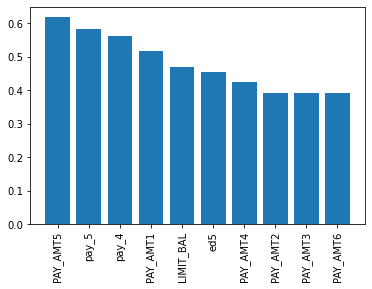

In [23]:
plt.bar(range(10), torch.topk(expl, k=10)[0].squeeze().detach().cpu().numpy())
labels = [df_normalized.columns[j] for j in torch.topk(expl, k=10)[1].squeeze().detach().cpu().numpy()]
labels
plt.xticks(ticks=range(10), labels=labels, rotation=90);

In [24]:
def project_L0_box_torch(y, k, lb, ub):
    x = torch.clone(y)
    p1 = torch.sum(x**2, dim=-1)
    p2 = torch.minimum(torch.minimum(ub - x, x - lb), torch.zeros_like(x))
    p2 = torch.sum(p2**2, dim=-1)
    p3 = torch.sort(torch.reshape(p1-p2, (p2.size()[0],-1)))[0][:,-k]
    x = x*(torch.logical_and(lb <=x, x <= ub)) + lb*(lb > x) + ub*(x > ub)
    x = x * torch.unsqueeze((p1 - p2) >= p3.reshape([-1, 1, 1]), -1)

    return x

In [26]:
x_projected = project_L0_box_torch(features_tensor_te[:10].unsqueeze(dim=2).unsqueeze(dim=3), 10, 0.0, 1.0)

In [27]:
x_projected = x_projected.squeeze(dim=3).squeeze(dim=2)

In [28]:
x_projected[0][torch.where(x_projected[0] > 0)[0]]

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.2726])

In [31]:
np.amax(np.abs((x_projected).cpu().detach().numpy()) > 1e-10, axis=0)

array([ True,  True,  True, False,  True,  True,  True, False, False,
       False, False,  True,  True, False,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False,  True,
        True,  True, False,  True, False, False, False, False, False,
       False,  True,  True,  True, False, False, False, False, False,
       False, False, False, False,  True,  True, False,  True, False,
       False, False, False, False, False, False,  True,  True,  True,
       False, False, False, False, False, False,  True,  True,  True,
        True, False, False, False,  True, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False])

In [33]:
torch.sum(x_projected > 1e-10, dim=1)

tensor([10, 10, 10, 10, 10, 10, 10, 10, 10, 10])

In [49]:
a = torch.tensor([1 if F.sigmoid(l)>0.5 else 0 for l in model(features_tensor_te[:20].to(device)).detach()])

device(type='cpu')

In [50]:
a==target_tensor_te[:20]

tensor([ True,  True,  True,  True, False,  True,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True])

In [48]:
target_tensor_te[:20][a==target_tensor_te[:20]].size()

torch.Size([18])